In [1]:
%config Completer.use_jedi=False
%matplotlib inline

In [2]:
import time
import copy
import glob
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet18, resnet34

C:\Users\acerKSG\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
data_transforms = transforms.Compose([
    transforms.Resize(size=(56, 56)),
    transforms.ToTensor(),
])

# Set up the data directory
data_dir = "archive/chest_xray/"

train_dataset = datasets.ImageFolder(data_dir+"train/", transform=data_transforms)
test_dataset = datasets.ImageFolder(data_dir+"test/", transform=data_transforms)

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

# Create the model and optimizer
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 56 * 56, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 2)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
model.train()
for epoch in range(3):
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
 
    print(f"Epoch [{epoch + 1}]: Train Loss: {running_loss / len(train_loader):.4f}")  

# Evaluate the model on the test set
correct = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {correct / len(test_dataset):.2%}")

Epoch [1]: Train Loss: 0.4390
Epoch [2]: Train Loss: 0.1766
Epoch [3]: Train Loss: 0.1761
Accuracy on the test set: 76.76%


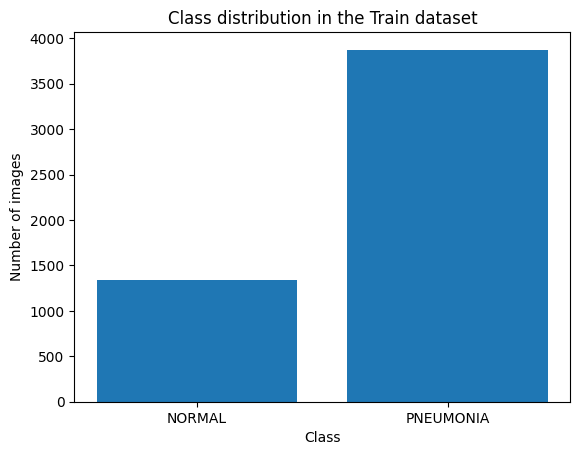

Train dataset mean: 0.4823, standard deviation: 0.2174


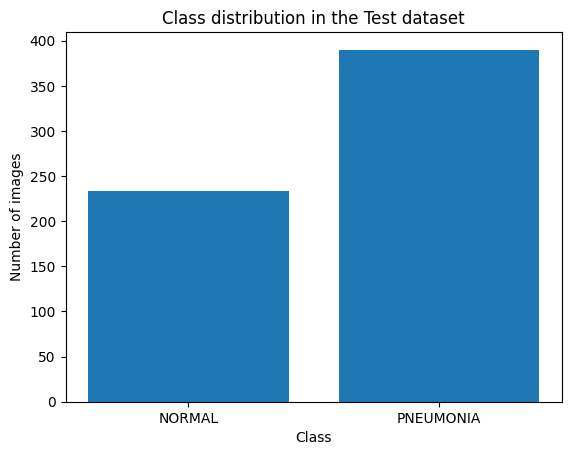

Test dataset mean: 0.4747, standard deviation: 0.2198


In [4]:
def visualize_class_distribution(dataset, dataset_name):
    class_counts = np.zeros(len(dataset.classes))
    for _, y in dataset:
        class_counts[y] += 1

    plt.bar(dataset.classes, class_counts)
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title(f"Class distribution in the {dataset_name} dataset")
    plt.show()

def calculate_dataset_stats(dataset):
    mean = 0.0
    std = 0.0
    for x, _ in dataset:
        mean += x.mean()
        std += x.std()
    
    mean /= len(dataset)
    std /= len(dataset)

    return mean.item(), std.item()

visualize_class_distribution(train_dataset, "Train")
mean, std = calculate_dataset_stats(train_dataset)
print(f"Train dataset mean: {mean:.4f}, standard deviation: {std:.4f}")

visualize_class_distribution(test_dataset, "Test")
mean, std = calculate_dataset_stats(test_dataset)
print(f"Test dataset mean: {mean:.4f}, standard deviation: {std:.4f}")

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize empty lists to store true labels and predictions
true_labels = []
predicted_labels = []
correct = 0

# Accumulate true labels and predictions for all mini-batches in the test set
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {correct / len(test_dataset):.2%}")

# Calculate precision, recall, and F1 score using the accumulated true labels and predictions
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1:.2f}")

Accuracy on the test set: 76.76%
Precision: 0.73, Recall: 0.98, F1 score: 0.84


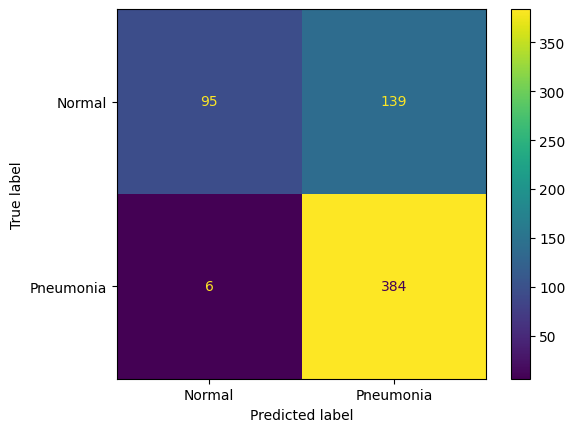

In [6]:
# Add imports at the top
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix using the accumulated true labels and predictions
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot()

In [7]:
def extract_patient_ids(filename):
    patient_id = filename.split('_')[0].replace("person", "")
    return patient_id

def split_file_names(input_folder, val_split_perc):
    # Pneumonia files contain patient id, so we group split them by patient to avoid data leakage
    pneumonia_patient_ids = set([extract_patient_ids(fn) for fn in os.listdir(os.path.join(input_folder, 'PNEUMONIA'))])
    pneumonia_val_patient_ids = random.sample(list(pneumonia_patient_ids), int(val_split_perc * len(pneumonia_patient_ids)))

    pneumonia_val_filenames = []
    pneumonia_train_filenames = []

    for filename in os.listdir(os.path.join(input_folder, 'PNEUMONIA')):
        patient_id = extract_patient_ids(filename)
        if patient_id in pneumonia_val_patient_ids:
            pneumonia_val_filenames.append(os.path.join(input_folder, 'PNEUMONIA', filename))
        else:
            pneumonia_train_filenames.append(os.path.join(input_folder, 'PNEUMONIA', filename))

    # Normal (by file, no patient information in file names)
    normal_filenames  = [os.path.join(input_folder, 'NORMAL', fn) for fn in os.listdir(os.path.join(input_folder, 'NORMAL'))]
    normal_val_filenames = random.sample(normal_filenames, int(val_split_perc * len(normal_filenames)))
    normal_train_filenames = list(set(normal_filenames)-set(normal_val_filenames))

    train_filenames = pneumonia_train_filenames + normal_train_filenames
    val_filenames = pneumonia_val_filenames + normal_val_filenames

    return train_filenames, val_filenames

In [11]:
import os

val_split = 0.2
train_filenames, val_filenames = split_file_names("archive/chest_xray/train/", val_split)

# Load the datasets
train_dataset = datasets.ImageFolder("archive/chest_xray/train/", transform=data_transforms, is_valid_file=lambda x: x in train_filenames)
val_dataset = datasets.ImageFolder("archive/chest_xray/train/", transform=data_transforms, is_valid_file=lambda x: x in val_filenames)    
test_dataset = datasets.ImageFolder("archive/chest_xray/test/", transform=data_transforms)

# Create the data loaders for train, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)    
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)

#return train_loader, val_loader, test_loader

In [12]:
# Function to compute validation loss
def validation_loss(model, val_loader):
    loss_fn = torch.nn.functional.cross_entropy
    total_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Call the validation loss function at the end of each epoch and output the results
for epoch in range(3):
    # ... (existing training loop code) ...
    val_loss = validation_loss(model, val_loader)
    print(f"Epoch [{epoch + 1}]: Train Loss: {running_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

Epoch [1]: Train Loss: 0.2188, Val Loss: 0.1169
Epoch [2]: Train Loss: 0.2188, Val Loss: 0.1168
Epoch [3]: Train Loss: 0.2188, Val Loss: 0.1274


In [13]:
# Initialize empty lists to store the loss history
train_loss_history = []
val_loss_history = []

# Train the model
for epoch in range(3):
    ...
    # Store the loss history
    train_loss = running_loss / len(train_loader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

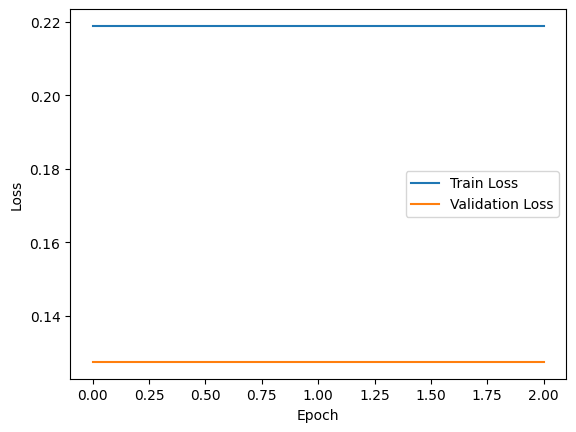

In [14]:
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
from tqdm import tqdm
progress_bar = tqdm(train_loader, desc="Training", leave=False, unit="mini-batch")
for inputs, labels in progress_bar:
    ...
    progress_bar.set_postfix(loss=loss.item())

In [16]:
import time

...

# Train the model
start_time = time.time()
for epoch in range(num_epochs):
    ...

    # Calculate elapsed time and remaining time
    elapsed_time = time.time() - start_time
    avg_time_per_epoch = elapsed_time / (epoch + 1)
    remaining_epochs = num_epochs - (epoch + 1)
    remaining_time = avg_time_per_epoch * remaining_epochs
     # Convert remaining time to minutes and seconds
    remaining_time_min, remaining_time_sec = divmod(remaining_time, 60)

    print(f"... Remaining Time: {remaining_time_min:.0f}m {remaining_time_sec:.0f}s")

NameError: name 'num_epochs' is not defined

In [ ]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

model = model.to(device)

In [ ]:
# Modify the training loop
for inputs, labels in progress_bar:
    inputs, labels = inputs.to(device), labels.to(device)
    ...

# Modify the evaluation loop
for inputs, labels in val_loader:
    inputs, labels = inputs.to(device), labels.to(device)          

# Modify the testing loop
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    ...

In [ ]:
true_labels.extend(labels.cpu().numpy())
predicted_labels.extend(predicted.cpu().numpy())

In [ ]:
import torch.nn.functional as F
...
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 56 * 56, 512),
    nn.ReLU(),
    nn.Linear(512, 2)
)
...
loss = F.cross_entropy(outputs, labels)

In [ ]:
criterion = nn.CrossEntropyLoss()
...
# Training loop
for inputs, labels in progress_bar:
    inputs, labels = inputs.to(device), labels.to(device)      
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)

In [ ]:
import pprint

h = {
    "num_epochs": 3,
    "batch_size": 64,
    "image_size": 56,
    "fc1_size": 512,
    "lr": 0.001
}

...

pprint.pprint(h)

In [ ]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Get number of CPU cores
num_cpu_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cpu_cores}")

# Get GPU name
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU name: {gpu_name}")
else:
    print("No GPU available")

In [ ]:
f1_array = np.array([])
accuracy_array = np.array([])
start_time = time.time()

repeats = 5
for i in range(repeats):
    print(f"Running solution {i+1}/{repeats}")
    f1, accuracy = check_solution(h, device, verbose=(i==0))
    print(f"F1 = {f1:.2f}, accuracy = {accuracy:.2f} ")
    f1_array = np.append(f1_array, f1)
    accuracy_array = np.append(accuracy_array, accuracy) 
    
repeat_time = (time.time() - start_time) / repeats
repeat_time_min, repeat_time_sec = divmod(repeat_time, 60)

# Printing final results
print("Results")
print(f"F1 List: {f1_array}")
print(f"Accuracy List: {accuracy_array}")
print(f"F1: {np.mean(f1_array):.1%} (+-{np.std(f1_array):.1%})")
print(f"Accuracy: {np.mean(accuracy_array):.1%} (+-{np.std(accuracy_array):.1%})")
print(f"Time of one solution: {repeat_time_min:.0f}m {repeat_time_sec:.0f}s")

print(f" | {np.mean(f1_array):.1%} (+-{np.std(f1_array):.1%}) | {np.mean(accuracy_array):.1%} (+-{np.std(accuracy_array):.1%}) | {repeat_time_min:.0f}m {repeat_time_sec:.0f}s")